# Hello GAN for generating for FMNIST style images

In [ ]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("TensorFlow Version: ", tf.__version__)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.0.2
Pandas Version:  2.2.3
TensorFlow Version:  2.18.0
Keras version: 3.8.0


The latest TensorFlow is based on Keras 3. Not everything needed for this sample is implemented in Keras 3, so need to revert back to Keras 2.  To use Keras 2.*, do the following:

- Import the `tf_keras` package.
- Set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` 

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

import tf_keras
print("tf_keras version:", tf_keras.__version__)

### Get Fashion MNIST Dataset

In [2]:
# Get dataset and split into training, validation, and test sets
f_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = f_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

### Define GAN generator and discrimator

In [3]:
tf.random.set_seed(42)

codings_size = 30

gan_generator = keras.Sequential([
    layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(28 * 28, activation="sigmoid"),
    layers.Reshape([28, 28])
])
gan_discriminator = keras.Sequential([
    tf.keras.layers.Flatten(),
    layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(1, activation="sigmoid")
])
gan = keras.Sequential([gan_generator, gan_discriminator])

#### Compile 

Generator will be trained only thru the GAN model, so need to compile it.  Discriminator should not be trined during the second phase of training, so set discriminator trainable to false for GAN model

In [4]:
gan_discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
gan_discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 28, 28)           │       136,634 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 1)                │       132,951 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,221 (1.55 MB)

 Trainable params: 136,634 (533.73 KB)

 Non-trainable params: 132,951 (519.34 KB)

 Optimizer params: 136,636 (533.74 KB)

#### Custom Training Loop

Create a dataset to iterate over images

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Training Loop

Helper function to visualize images

In [6]:
def viz_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [11]:
generator, discriminator = gan.layers
print(generator)


<Sequential name=sequential, built=True>


In [7]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # phase 1: train the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2: train the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # Vizualize images during training
        viz_multiple_images(generated_images.numpy(), 8)
        plt.show()

Epoch 1/50


d:\MyGithub\ML_TensorFlow_Keras_Experiments\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


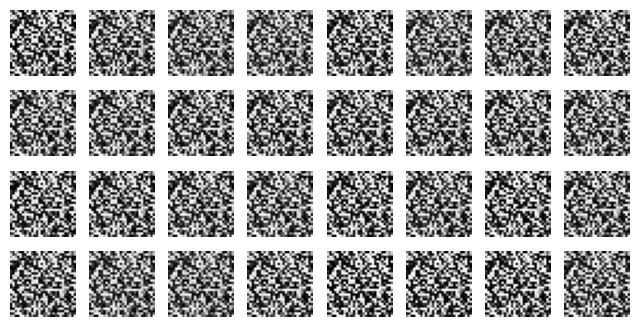

Epoch 2/50


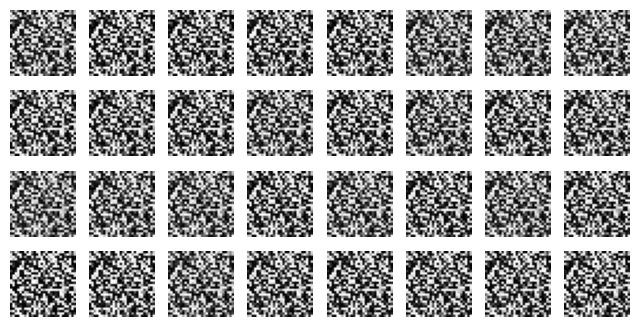

Epoch 3/50


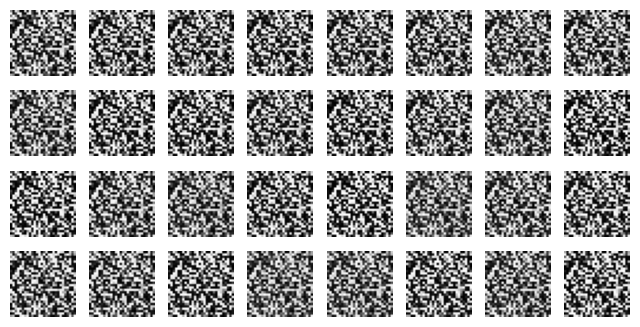

Epoch 4/50


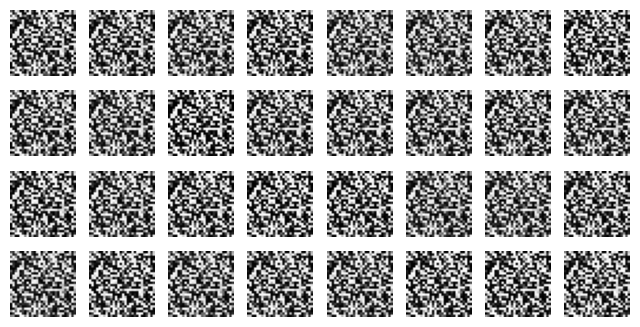

Epoch 5/50


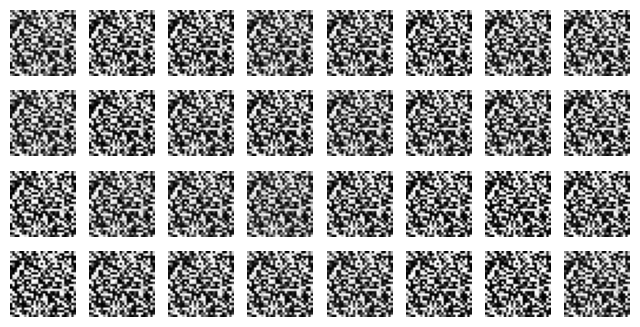

Epoch 6/50


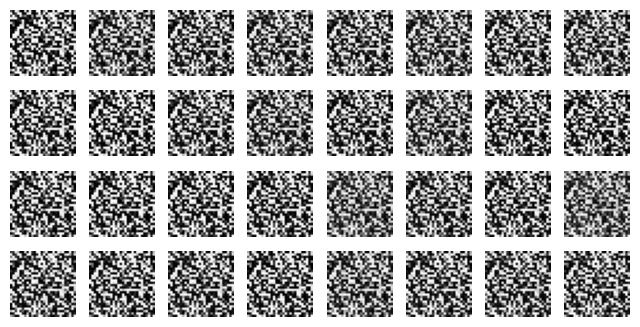

Epoch 7/50


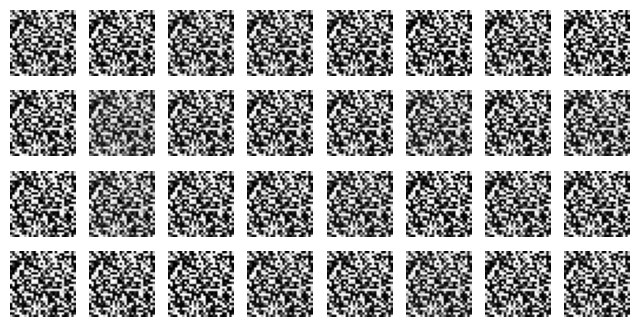

Epoch 8/50


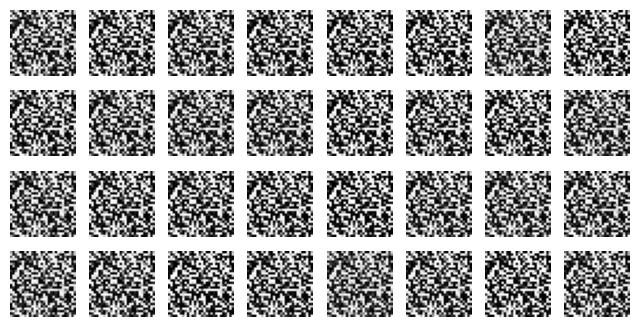

Epoch 9/50


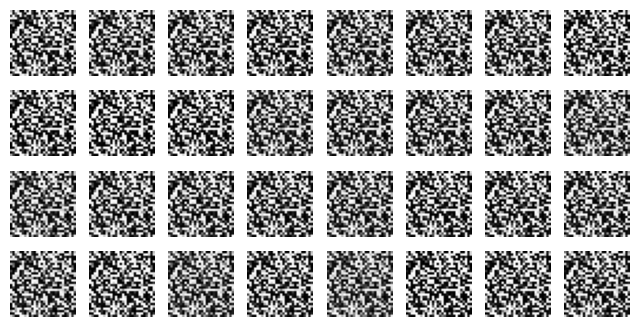

Epoch 10/50


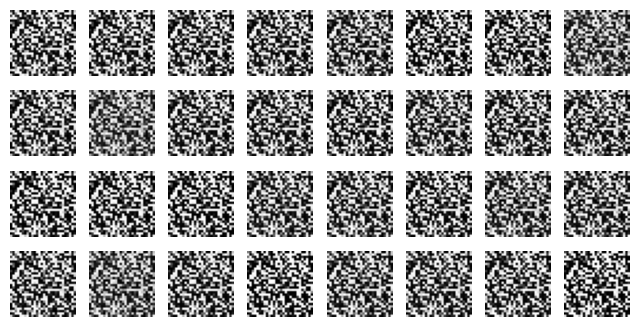

Epoch 11/50


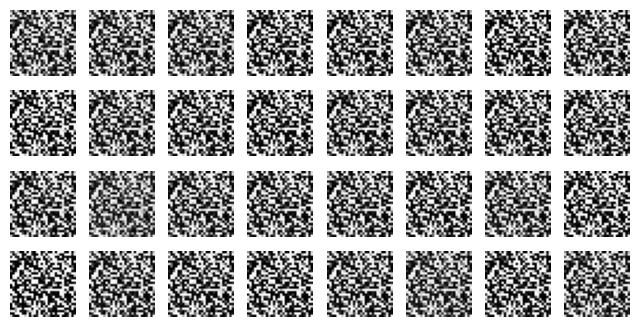

Epoch 12/50


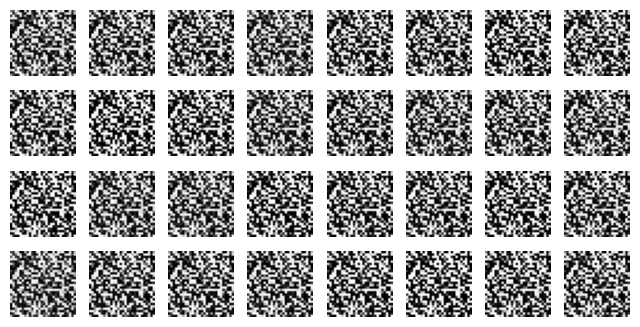

Epoch 13/50


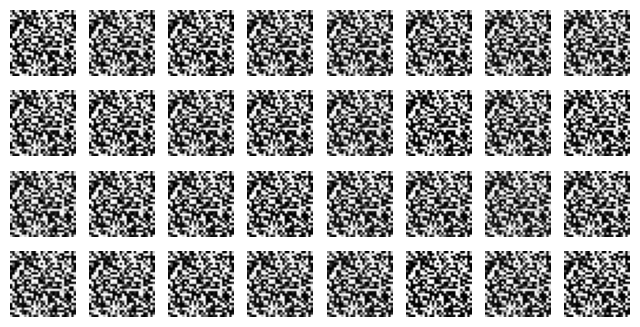

Epoch 14/50


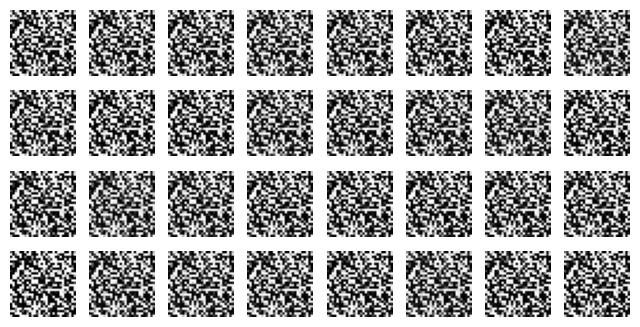

Epoch 15/50


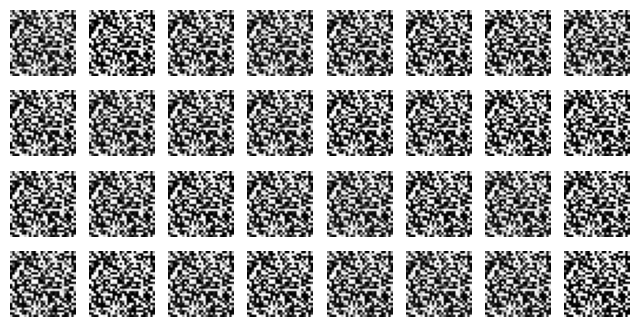

Epoch 16/50


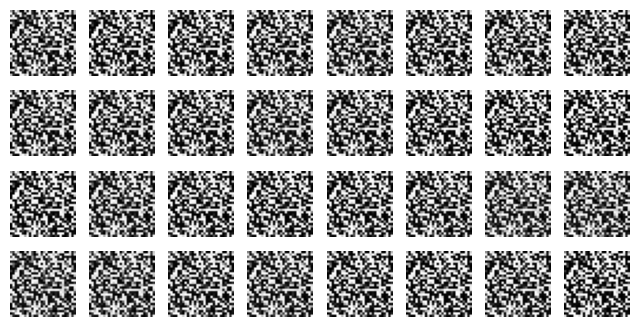

Epoch 17/50


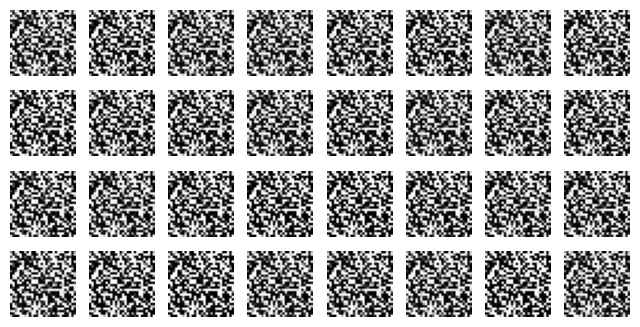

Epoch 18/50


KeyboardInterrupt: 

In [8]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)